In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from scipy import stats
from statsmodels.stats import proportion
from pingouin import mixed_anova

from psyfun import io, atlas, spikes, plots
from psyfun.config import *

In [3]:
# Load the session and unit metadata
df_sessions = pd.read_parquet(paths['sessions'])  # session info
df_sessions = df_sessions.query('n_tasks >= 2').dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])
df_sessions = df_sessions[df_sessions['eid'] != 'e31bff07-d66c-4a03-894d-f71030161ead']

In [4]:
df_units = pd.read_parquet(paths['units'])  # unit info
df_units['coarse_region'] = atlas.coarse_regions(df_units['region'])

In [5]:
eids = df_sessions['eid'].to_list()

# Find good-quality units from those sessions
df_unitquery = df_units.query('eid in @eids and ks2_label == "good"')
# Load spike times for good units
uuids = df_unitquery['uuid'].tolist()
df_spiketimes = io.load_units(paths['spikes'], uuids)
# Join spike times with unit info
df_spikes = df_unitquery.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessions, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:11<00:00, 1258.02it/s]


In [5]:
task_epochs = ['task00_spontaneous', 'task00_replay', 'task01_spontaneous', 'task01_replay']
lsd_epochs = ['LSD0', 'LSD600', 'LSD1200']

epochs = task_epochs
dt = 1  # get spike counts in 1s bins

for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())
    df_spikes[f'{epoch}_lograte'] = np.log10(df_spikes[f'{epoch}_rate'])

Getting spike counts for: task00_spontaneous


100%|███████████████████████████████████| 14886/14886 [00:04<00:00, 3370.42it/s]
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task00_replay


100%|███████████████████████████████████| 14886/14886 [00:04<00:00, 3247.31it/s]
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task01_spontaneous


100%|███████████████████████████████████| 14886/14886 [00:04<00:00, 3198.87it/s]
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task01_replay


100%|███████████████████████████████████| 14886/14886 [00:04<00:00, 3302.59it/s]
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
fig, ax = plt.subplots()

xpos = np.arange(len(task_epochs))
offsets = {True: -0.15, False: 0.15}
for control, group_data in df_spikes.groupby('control_recording'):
    rates = [group_data[f'{epoch}_lograte'].replace(-np.inf, np.nan).dropna() for epoch in task_epochs]
    boxes = ax.boxplot(rates, positions=xpos + offsets[control], widths=0.25)
    color = cmaps['control'](1.) if control else cmaps['LSD'](1.)
    # violins = ax.violinplot(rates, positions=xpos + offsets[control], showmedians=True, showextrema=False)
    for box, median in zip(boxes['boxes'], boxes['medians']):
        box.set_color(color)
        box.set_linewidth(2)
        median.set_color(color)
        median.set_linewidth(2)
ax.set_xticks(xpos)
ax.set_xticklabels(task_epochs)
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.linspace(-3, 3, 7))
ax.set_yticklabels(['$10^{%d}$' % tick for tick in np.linspace(-3, 3, 7)])
ax.set_ylabel('log(rate)')

df_rates = df_spikes.melt(
    id_vars=['subject', 'uuid', 'control_recording'],
    value_vars=[col for col in df_spikes.columns if col.endswith('_lograte')],
    var_name='epoch',
    value_name='lograte'
).replace(-np.inf, np.nan).dropna()
df_rates['epoch'] = df_rates['epoch'].str.replace('_lograte', '', regex=False)
mixed_anova(df_rates, dv='lograte', within='epoch', between='control_recording', subject='uuid')

In [5]:
df_spikes['LSD_start'] = df_spikes['LSD_admin'] - 5 * 60
df_spikes['LSD_stop'] = df_spikes['LSD_admin'] + 30 * 60

dt = 1
df_spikes[f'LSD_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch='LSD', dt=dt, axis='columns')
df_spikes[f'LSD_rate'] = df_spikes[f'LSD_counts'].apply(lambda x: (x / dt).mean())

100%|███████████████████████████████████| 14886/14886 [00:05<00:00, 2773.85it/s]


In [9]:
import ruptures as rpt

def binseg(y):
    return rpt.Binseg().fit(y).predict(n_bkps=1)

df_spikes['bkpts'] = df_spikes['LSD_counts'].progress_apply(binseg)

100%|█████████████████████████████████████| 14886/14886 [12:47<00:00, 19.41it/s]


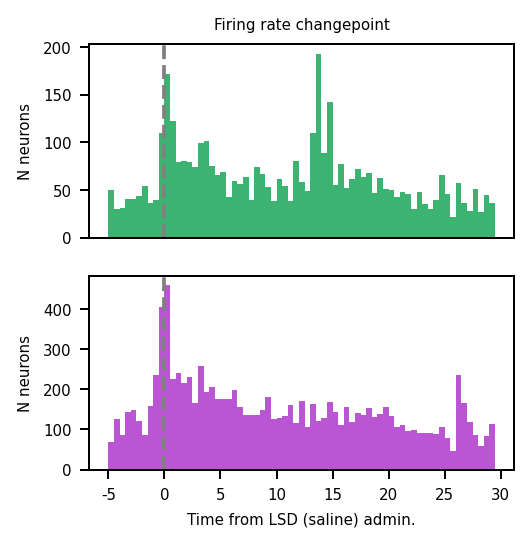

In [38]:
fig, axs = plt.subplots(2)

df = df_spikes.query('control_recording == True')
axs[0].hist(df['bkpts'].apply(lambda x: x[0]), bins=np.arange(0, 35 * 60, 30), color=CONTROLCOLOR)
axs[0].axvline(5 * 60, ls='--', color='gray')
df = df_spikes.query('control_recording == False')
axs[1].hist(df['bkpts'].apply(lambda x: x[0]), bins=np.arange(0, 35 * 60, 30), color=LSDCOLOR)
axs[1].axvline(5 * 60, ls='--', color='gray')

axs[0].set_title('Firing rate changepoint')
axs[0].set_xticks([])
axs[1].set_xticks(np.arange(0, 40 * 60, 300))
axs[1].set_xticklabels(np.arange(0, 40, 5, dtype=int) - 5)
axs[1].set_xlabel('Time from LSD (saline) admin.')
axs[0].set_ylabel('N neurons')
axs[1].set_ylabel('N neurons')

plots.set_plotsize(w=6)

In [ ]:
# Get firig rate modulation index
epoch_pairs = {
    'spontaneous': ['task00_spontaneous', 'task01_spontaneous'],
    'replay': ['task00_replay', 'task01_replay']
}

MIs = df_spikes.progress_apply(spikes._get_modulation_index, epoch_pairs=epoch_pairs, axis='columns')

In [88]:
MIs

0        {'spontaneous_MI': -0.011037527593818985, 'spo...
1        {'spontaneous_MI': -0.015173505739543475, 'spo...
2        {'spontaneous_MI': 0.04573170731707317, 'spont...
3        {'spontaneous_MI': 0.014360313315926894, 'spon...
4        {'spontaneous_MI': 0.08608058608058608, 'spont...
                               ...                        
14881    {'spontaneous_MI': 0.03076923076923077, 'spont...
14882    {'spontaneous_MI': 0.6835106382978723, 'sponta...
14883    {'spontaneous_MI': -0.5429459774582199, 'spont...
14884    {'spontaneous_MI': 0.15831663326653306, 'spont...
14885    {'spontaneous_MI': 0.28484848484848485, 'spont...
Length: 14886, dtype: object

In [98]:
df_MI = pd.DataFrame(MIs.to_list(), index=df_spikes.index).map(lambda x: float(x) if isinstance(x, np.ndarray) else x)

In [99]:
df_MI['spontaneous_p']

0        0.13
1        0.09
2        0.87
3        0.71
4        1.00
         ... 
14881    0.53
14882    1.00
14883    0.00
14884    1.00
14885    1.00
Name: spontaneous_p, Length: 14886, dtype: float64

In [102]:
df_spikes = pd.concat([df_spikes, df_MI], axis=1)

In [103]:
columns_to_keep = [
    'uuid', 'eid', 'subject', 'n_probes', 'n_tasks', 'start_time', 'control_recording', 'session_n',
    'amp_median', 'contamination', 'drift', 'label', 
    'x', 'y', 'z', 'region', 'coarse_region',
    'spontaneous_MI', 'spontaneous_p', 'replay_MI', 'replay_p'
]
df_spikes[columns_to_keep].to_parquet('data/MIs.pqt')

In [6]:
df_MI = pd.read_parquet('data/MIs.pqt')

0.7377904220009484


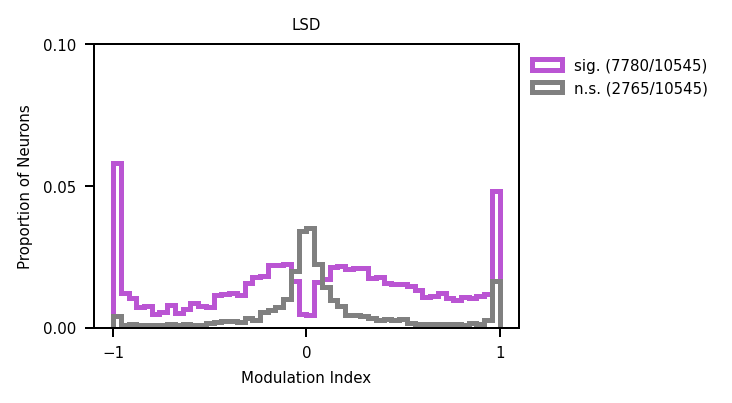

In [117]:
control = False
epoch = 'replay'
fig, ax = plt.subplots()
title = 'Control' if control else 'LSD'
ax.set_title(title)
df_condition = df_MI.query('control_recording == @control')

queries = [
    f'{epoch}_p <= 0.025 or {epoch}_p >= 0.975',
    f'{epoch}_p > 0.025 and {epoch}_p < 0.975'
]
cmap = cmaps['control'] if control else cmaps['LSD']
colors = [cmap(1.), cmap(0.)]

for query, color, label in zip(queries, colors, ['sig.', 'n.s.']):
    df_sig = df_condition.query(query)
    weights = np.ones(len(df_sig)) / len(df_condition)
    label = f'{label} ({len(df_sig)}/{len(df_condition)})'
    ax.hist(df_sig[f'{epoch}_MI'], bins=50, weights=weights, histtype='step', linewidth=2, color=color, label=label)

ax.set_xticks([-1, 0, 1])
ax.set_xlabel('Modulation Index')
ax.set_yticks([0, 0.05, 0.1])
ax.set_ylabel('Proportion of Neurons')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plots.set_plotsize(w=6, h=4)
print(len(df_condition.query(queries[0])) / len(df_condition))

In [28]:
# Make a df only with units mapped to a region
# df_regions = df_spikes.dropna(subset='region').copy()
df_regions = df_spikes.replace({'region': {None: 'root'}}).copy()
# Merge region acronyms into coarse regions
df_regions['coarse_region'] = atlas.combine_regions(df_regions['region'])
df_regions = df_regions.query('region != "root"')

SyntaxError: Python keyword not valid identifier in numexpr query (<unknown>, line 1)

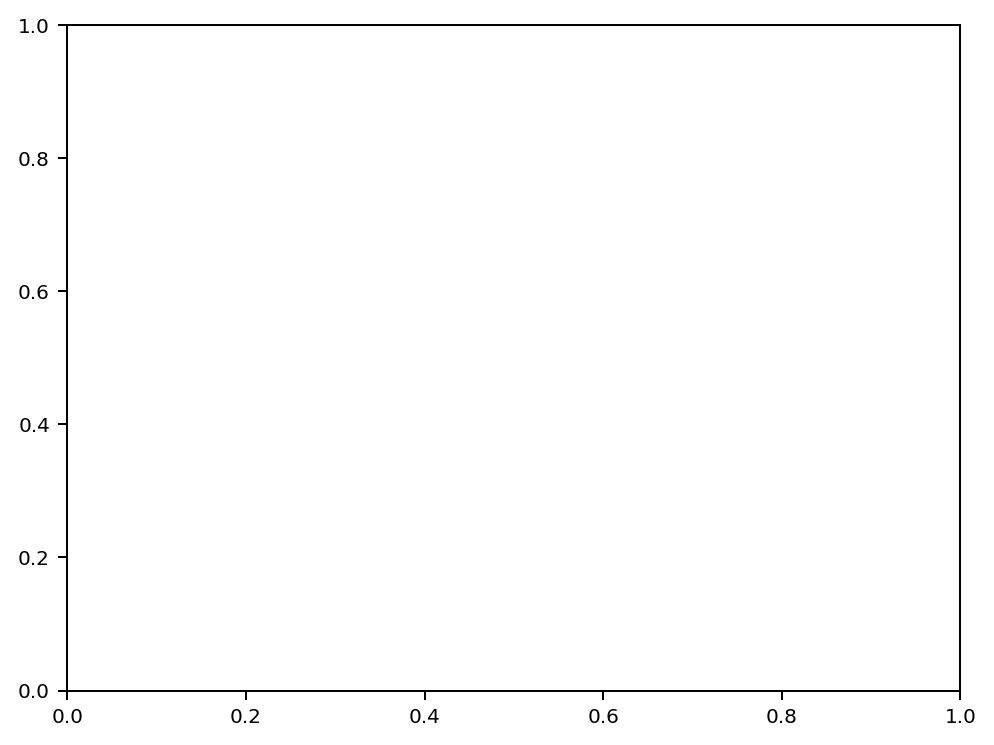

In [8]:
control = False
epoch = 'spontaneous'
fig, ax = plt.subplots()
n_regions = 50

df = df_MI.query('control_recording == @control')

# Count neurons per region-eid
n_neurons = df.groupby('coarse_region').size()

# Count neurons with significant modualtion (2-sided test) per region-eid
n_significant = df.query(f'{epoch}_p <= 0.025 or {epoch}_p => 0.975').groupby('coarse_region').size()

# Proportion of significant neurons
MI_props = (n_significant / n_neurons).reset_index(name='MI_prop')  # .query('coarse_region != "root"')
MI_regions = MI_props.groupby('coarse_region')['MI_prop']

MIs = MI_regions.mean()
y_neg, y_pos = proportion.proportion_confint(n_significant, n_neurons, alpha=0.5)
yerr = np.vstack([MIs - y_neg, y_pos - MIs])
n_sessions = MI_regions.size()
sorted_inds = np.argsort(-1 * MIs)
xpos = np.arange(len(MIs))

cmap = cmaps['control'] if control else cmaps['LSD']
colors = np.array([cmap(p) for p in MIs / MIs.max()])

ax.bar(xpos, MIs[sorted_inds], yerr=yerr[:, sorted_inds], fc=colors[sorted_inds], ec='gray')
ax.set_xticks(np.arange(len(MIs)))
ax.set_xticklabels(MIs.index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Proportion of units')

plots.set_plotsize(w=8, h=4)

In [9]:
df_MI['coarse_region'] = atlas.coarse_regions(df_MI['region'])

NameError: name 'mixed_lm' is not defined

> /tmp/ipykernel_40616/607038568.py(13)<module>()
     11 # Compute means and errors for each group (control and LSD/experimental)
     12 MI = df.groupby(['coarse_region', 'control_recording'])[f'{epoch}_MI'].agg(['mean', 'sem']).unstack()
---> 13 pvals = df.groupby('coarse_region').apply(mixed_lm)
     14 
     15 xpos = np.arange(len(sorted_regions))



ipdb>  c


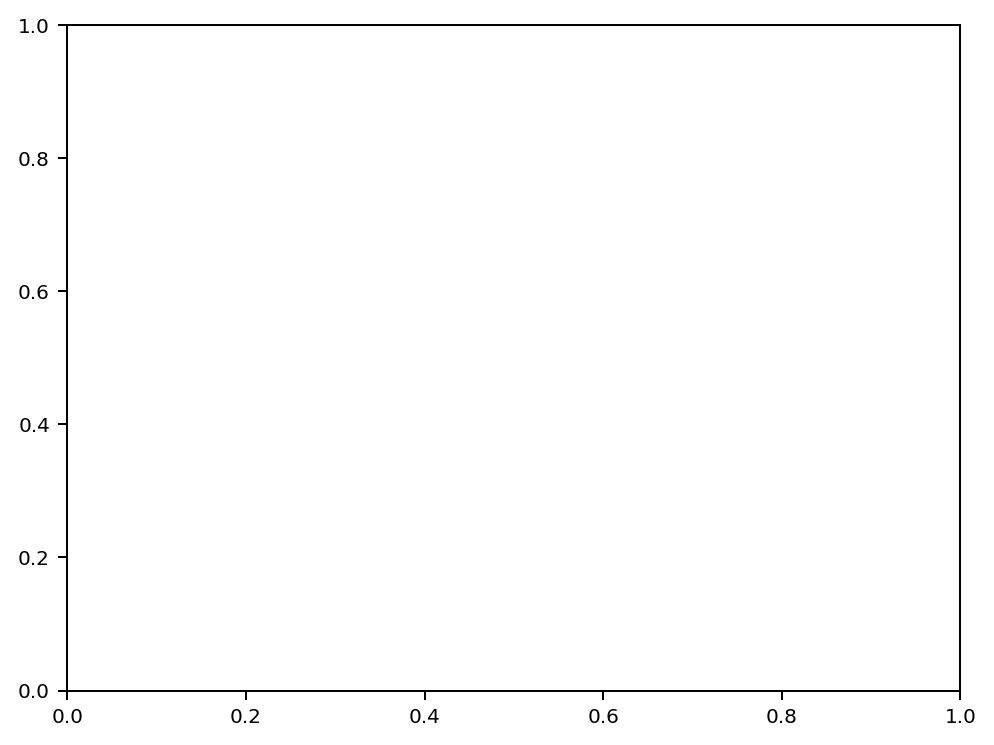

In [10]:
epoch = 'spontaneous'
fig, ax = plt.subplots()

# Prepare data: keep only significant neurons
df = df_MI.dropna(subset=[f'{epoch}_MI']).query(f'{epoch}_p < 0.025 or {epoch}_p > 0.975')

# Compute mean MI per region (all data), for sorting
region_means = df.groupby('coarse_region')[f'{epoch}_MI'].mean()
sorted_regions = region_means.sort_values(ascending=False).index.tolist()

# Compute means and errors for each group (control and LSD/experimental)
MI = df.groupby(['coarse_region', 'control_recording'])[f'{epoch}_MI'].agg(['mean', 'sem']).unstack()
pvals = df.groupby('coarse_region').apply(mixed_lm)

xpos = np.arange(len(sorted_regions))
for control, offset in zip([False, True], [-0.15, 0.15]):
    means = MI['mean'].loc[sorted_regions, control].values
    err   = MI['sem'].loc[sorted_regions, control].values * 1.96
    color = CONTROLCOLOR if control else LSDCOLOR
    ax.bar(xpos + offset, means, yerr=err, width=0.25, color=color, edgecolor='k')

for i, region in enumerate(sorted_regions):
    p = pvals.loc[region] if region in pvals.index else np.nan
    h_control = MI['mean'].loc[region, False]
    h_lsd   = MI['mean'].loc[region, True]
    ypos = h_control if np.abs(h_control) > np.abs(h_lsd) else h_lsd
    ax.text(xpos[i], ypos + (0.1 * np.sign(ypos)), pval2stars(p), ha='center', va='bottom', fontsize=plots.LABELFONTSIZE, fontweight='bold', color='k')

ax.axhline(0, color='k', linewidth=1, linestyle='--')
ax.set_xticks(xpos)
ax.set_xticklabels(sorted_regions, rotation=90)
ax.set_yticks([-1, 0, 1])
ax.set_ylabel('Mean MI')

# ax.text(xpos[0] - 1, 0.01, 'Higher rate after treatment >', fontsize=plots.LABELFONTSIZE, va='bottom', ha='left', rotation=90)
# ax.text(xpos[-1] + 1, -0.01, 'Lower rate after treatment >', fontsize=plots.LABELFONTSIZE, va='top', ha='right', rotation=270)
ax.text(0.01, 1.01, 'Linear Mixed-effects Model: p < 0.05: *, p < 0.01: **, p < 0.001: ***', 
        transform=ax.transAxes, fontsize=plots.LABELFONTSIZE)

plots.set_plotsize(w=14, h=6)

In [133]:
import statsmodels.formula.api as smf

def mixed_lm(group, method='lbfgs', maxiter=100):
    group.reset_index(drop=True, inplace=True)

    if (group['control_recording'].nunique() < 2) or (group.groupby('control_recording')['eid'].nunique().min() < 2):
        # print("Skipping coarse_region:", idx)
        # print("group shape:", group.shape)
        # print("unique eids:", group['eid'].nunique())
        # print("unique control_recording:", group['control_recording'].unique())
        return np.nan

    model = smf.mixedlm(f'{epoch}_MI ~ control_recording', group, groups=group["eid"])
    result = model.fit()
    if result.converged:
        return result.pvalues['control_recording[T.True]']
    else:
        print(result.params)
        return np.nan

def pval2stars(p):
    if np.isnan(p):
        return 'n/a'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [156]:
def bootstrap_median_ci(data, n_bootstrap=1000, alpha=0.05):
    """
    Compute a bootstrap confidence interval for the median of an array.
    
    Parameters
    ----------
    data : array_like
        The data from which to compute the median.
    n_bootstrap : int, optional
        The number of bootstrap samples to use. Default is 1000.
    alpha : float, optional
        Significance level (e.g. 0.05 gives a 95% CI).
        
    Returns
    -------
    (ci_lower, ci_upper) : tuple of floats
        The lower and upper bounds of the bootstrap confidence interval.
    """
    medians = np.empty(n_bootstrap)
    n = len(data)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        medians[i] = np.median(sample)
    ci_lower = np.percentile(medians, 100 * (alpha / 2))
    ci_upper = np.percentile(medians, 100 * (1 - alpha / 2))
    return ci_lower, ci_upper

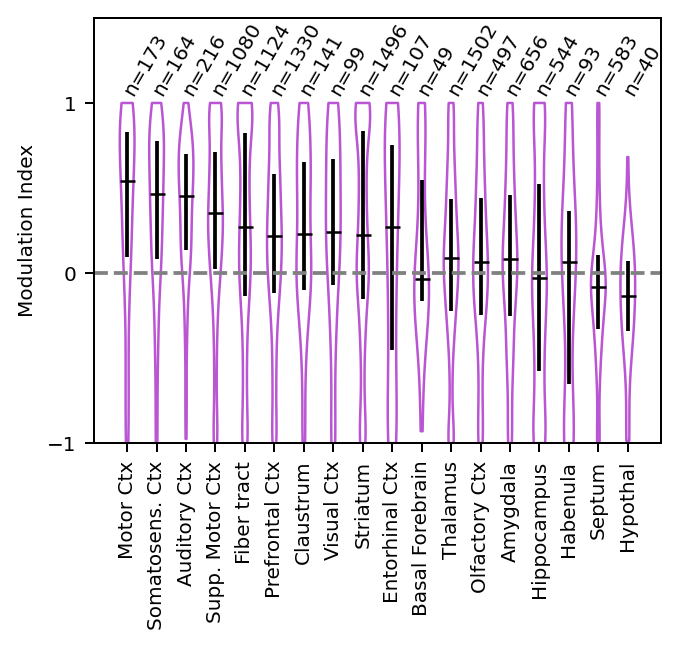

In [40]:
control = False
epoch = 'spontaneous'

fig, ax = plt.subplots()
cmap = cmaps['control'] if control else cmaps['LSD']

df = df_MI.query('control_recording == @control')
regions = df.groupby('coarse_region')
xpos = np.arange(len(regions))
region_labels = np.array(list(regions.groups.keys()))
MIs = [region[f'{epoch}_MI'].dropna().values for _, region in regions]
# sorted_inds = np.argsort([np.median(MI) for MI in MIs])
sorted_MIs = [MIs[i] for i in sorted_inds]
# cis = [bootstrap_median_ci(mi) for mi in sorted_MIs]
cis = [np.quantile(mi, [.25, .75]) for mi in sorted_MIs]

violins = ax.violinplot(sorted_MIs, positions=xpos, showmedians=False, showextrema=False)
for violin in violins['bodies']:
    violin.set_facecolor('none')
    violin.set_edgecolor(cmap(1.))
    violin.set_linewidth(1)
    violin.set_alpha(1)
for i, (mi, (ci_lower, ci_upper)) in enumerate(zip(sorted_MIs, cis)):
    med = np.median(mi)
    ax.errorbar(xpos[i], med, yerr=[[med - ci_lower], [ci_upper - med]], fmt='_', color='black')
ax.axhline(0, ls='--', color='gray')
for x, units in zip(xpos, sorted_MIs):
    ax.text(x - 0.25, 1.05, f'n={len(units)}', fontsize=plots.LABELFONTSIZE, rotation=60)
ax.set_xticks(xpos)
ax.set_xticklabels(region_labels[sorted_inds])
ax.tick_params(axis='x', rotation=90)
ax.set_yticks([-1, 0, 1])
ax.set_ylim([-1.1, 1.4])
ax.set_ylabel('Modulation Index')
ax.set_ylim([-1, 1.5])
plots.set_plotsize(w=8, h=6)

In [15]:
sorted_regions

['Motor Ctx',
 'Somatosens. Ctx',
 'Auditory Ctx',
 'Supp. Motor Ctx',
 'Fiber tract',
 'Prefrontal Ctx',
 'Claustrum',
 'Visual Ctx',
 'Striatum',
 'Entorhinal Ctx',
 'Basal Forebrain',
 'Thalamus',
 'Olfactory Ctx',
 'Amygdala',
 'Hippocampus',
 'Habenula',
 'Septum',
 'Hypothal']

In [31]:
sorted_inds = np.array([np.where(np.array(list(regions.groups.keys())) == region)[0][0] for region in sorted_regions])

In [32]:
sorted_inds

array([ 9, 13,  1, 15,  5, 11,  3, 17, 14,  4,  2, 16, 10,  0,  7,  6, 12,
        8])

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False])